<h1><center> MATH 572 Computational Statistics - Spring 2020 </h1></center>
<h2><center> Final EXAM - Coding Part </h2></center>
<h3><center> Instructor: Leming Qu </h3></center>
<h4><center> May 5 (Tuesday), 5:00 PM - May 7 (Thursday) 11:59AM </h4></center>

<h1><center> Student: Arash Modaresi Rad </h1></center>

In [1]:
import time
import numpy as np
import seaborn as sb
import sympy as sym
from sympy import *
import pandas as pd 
import matplotlib.pyplot as plt  
from tabulate import tabulate as tabulate
from sklearn.model_selection import KFold 
from sklearn.model_selection import RepeatedKFold
#from prettytable import PrettyTable

np.random.seed(1100)

**1. reproduce Figure 11.3 on page 369;**

These data are n = 200 equally spaced
points from the model Yi = s (xi) + i, where the errors are mean-zero i.i.d. normal
noise with a standard deviation of 1.5. The data are available from the website for this
book. The true relationship, s(x) = x^3 sin {(x + 3.4)/2}

In [2]:
data = pd.read_table("easysmooth.dat", sep="\s+")
data.head()

,X,Y
0,-3.500,0.132
1,-3.467,-0.961
2,-3.435,3.369
3,-3.402,0.147
4,-3.369,1.449


In [3]:
X = data['X']
Y = data['Y']

In [4]:
def truncated_neighborhood_moving_average(K, y):
    n = np.size(y)
    Mat = np.zeros((n, n))
    Updated_K = int((K-1)/2)
    
    ## Check the value of K
    if K == 1:
        Mat = np.identity(n)
        
    elif K > 1:
        for i in range(Updated_K):
            Mat[i][0:(Updated_K + i + 1)] = 1 / (K - Updated_K + i)
            Mat[n - 1 - i][(n - Updated_K - i):n] = 1 / (K - Updated_K + i)
            
        for i in range(Updated_K, n-Updated_K):
            Mat[i][(i-Updated_K):(Updated_K + i + 1)] = 1 / K
            
    else:
        raise Exception('K should not be less than 1 and should be an odd number. The value of K was: {}'.format(K))
        
    Result = np.dot(Mat, y)
    return Result
    

In [5]:
s3  = truncated_neighborhood_moving_average(3, Y)
s13 = truncated_neighborhood_moving_average(13, Y)
s43 = truncated_neighborhood_moving_average(43, Y)

<Figure size 432x288 with 0 Axes>

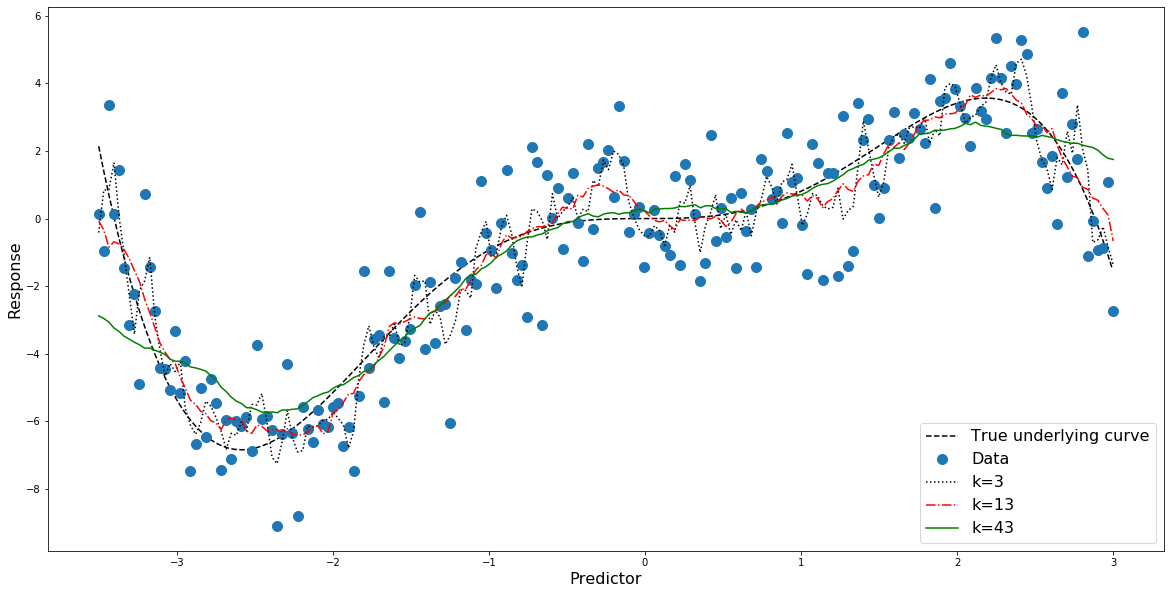

In [6]:
fig = plt.figure()
plt.figure(figsize=(20,10))
ax = plt.axes()
seq = np.arange(np.min(X),np.max(X), ((np.max(X)-np.min(X))/1000))
ax.plot(seq, (seq**3)*np.sin((seq+3.4)/2), 'k--', label='True underlying curve')
ax.plot(X, Y, 'o', markersize=10, label='Data')
ax.plot(X, s3, 'k:', label='k=3')
ax.plot(X, s13, 'r-.', label='k=13')
ax.plot(X, s43, 'g-', label='k=43')
plt.legend(fontsize=16)
plt.xlabel('Predictor', fontsize=16)
plt.ylabel('Response',fontsize=16)
plt.show()

Results from a constant-span running-mean smoother with k = 3 (wigglier
solid line) and k = 43 (smoother solid line). The underlying true curve is shown with a
dotted line.

**2. reproduce Figure 11.4 on page 370 - plot A: CVRSSk(^ sk) versus k using equation (11.16),**

>`The approach of leave-one-out cross-validation:`

cross-validated residual sum of squares

In [7]:
def CVRSS(K, y):
    n = np.size(y)
    Mat = np.zeros((n, n))
    Updated_K = int((K-1)/2)
    
    ## Check the value of K
    if K == 1:
        Mat = np.identity(n)
        
    elif K > 1:
        for i in range(Updated_K):
            Mat[i][0:(Updated_K + i + 1)] = 1 / (K - Updated_K + i)
            Mat[n - 1 - i][(n - Updated_K - i):n] = 1 / (K - Updated_K + i)
            
        for i in range(Updated_K, n-Updated_K):
            Mat[i][(i-Updated_K):(Updated_K + i + 1)] = 1 / K
            
    else:
        raise Exception('K should not be less than 1 and should be an odd number. The value of K was: {}'.format(K))
        
    Result = np.sum(((y - np.dot(Mat, y)) ) ** 2)
    return Result

Lets compute average time for this model as well:

In [8]:
M = 50
K_seq = np.arange(2, M+1, 2)
Values = np.zeros(K_seq.size)
j = 0

start_time = time.time()
for i in K_seq:
    Values[j] = CVRSS(i, Y)
    j += 1
    
A_time = (time.time() - start_time) / j

<Figure size 432x288 with 0 Axes>

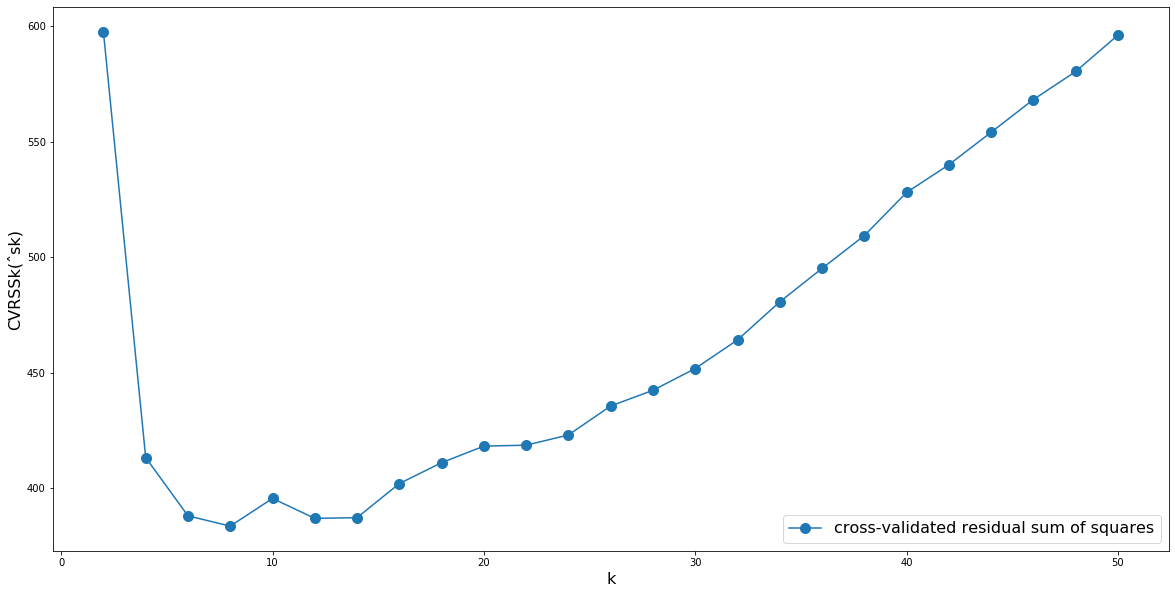

In [9]:
fig = plt.figure()
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.plot(K_seq, Values, '-o', markersize=10, label='cross-validated residual sum of squares')
plt.legend(fontsize=16)
plt.xlabel('k', fontsize=16)
plt.ylabel('CVRSSk(ˆsk)',fontsize=16)
plt.show()

Plot of CVRSSk(sˆk) versus k for the constant-span running-mean smoother
applied to the data in Figure 11.1. Good choices for k range between about `6 and 14`. The
smaller values in this range would be especially good at bias reduction, whereas the larger ones
would p

**3. produce plot B: CVRSSk(^ sk) versus k using equation (11.18)**

>`The First shortcut:`

In this case, to compute CVRSSk(sˆk) there is no need to actually delete
the ith observation and recompute the smooth for each i

In [10]:
def CVRSS_2(K, y):
    n = np.size(y)
    Mat = np.zeros((n, n))
    Updated_K = int((K-1)/2)
    
    ## Check the value of K
    if K == 1:
        Mat = np.identity(n)
        
    elif K > 1:
        for i in range(Updated_K):
            Mat[i][0:(Updated_K + i + 1)] = 1 / (K - Updated_K + i)
            Mat[n - 1 - i][(n - Updated_K - i):n] = 1 / (K - Updated_K + i)
            
        for i in range(Updated_K, n-Updated_K):
            Mat[i][(i-Updated_K):(Updated_K + i + 1)] = 1 / K
            
    else:
        raise Exception('K should not be less than 1 and should be an odd number. The value of K was: {}'.format(K))
        
    Result = np.sum(((y - np.dot(Mat, y)) / (1 - np.diag(Mat))) ** 2)
    return Result

Lets compute average time for this model as well:

In [11]:
M = 50
K_seq_2 = np.arange(3, M+1, 2)
Values_2 = np.zeros(K_seq_2.size)
j = 0

start_time = time.time()
for i in K_seq_2:
    Values_2[j] = CVRSS_2(i, Y)
    j += 1

B_time = (time.time() - start_time) / j

<Figure size 432x288 with 0 Axes>

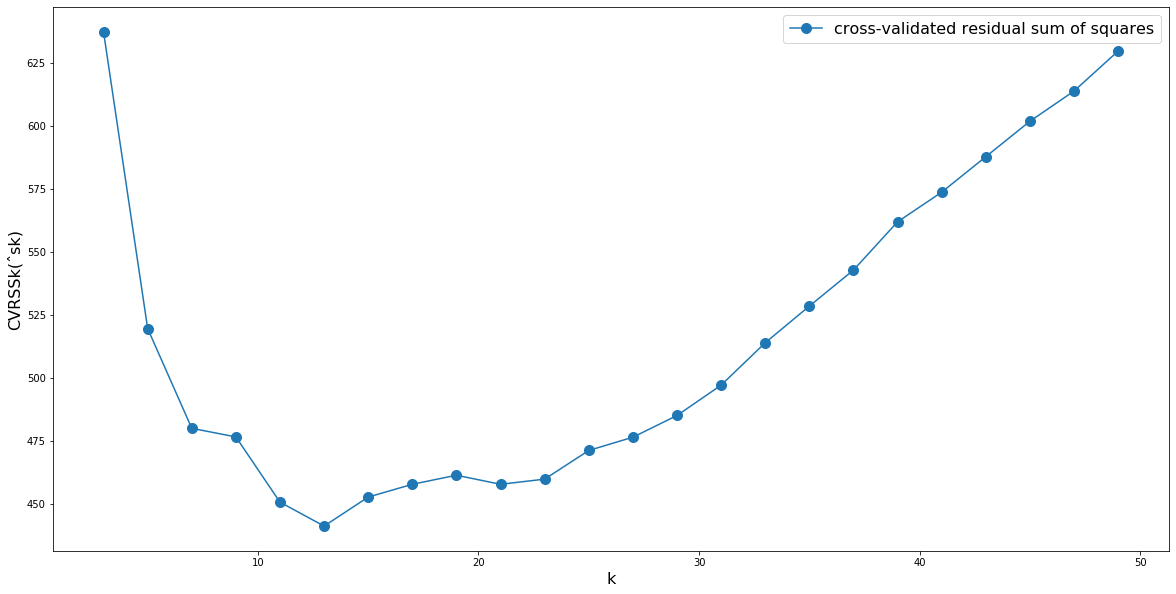

In [12]:
fig = plt.figure()
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.plot(K_seq_2, Values_2, '-o', markersize=10, label='cross-validated residual sum of squares')
plt.legend(fontsize=16)
plt.xlabel('k', fontsize=16)
plt.ylabel('CVRSSk(ˆsk)',fontsize=16)
plt.show()

The above plot shows a plot of CVRSSk(sˆk)
against k for smoothing the data introduced in Example 11.1. This plot usually shows
a steep increase in CVRSSk(sˆk) for small k due to increasing variance, and a gradual increase in CVRSSk(sˆk) for large k due to increasing bias. The region of best
performance is where the curve is lowest; this region is often quite broad and rather
flat. In this example, good choices of k range between `11 and 23`, with k = 13 being
optimal. Minimizing CVRSSk(sˆk) with respect to k often produces a final smooth
that is somewhat too wiggly. Undersmoothing can be reduced by choosing a larger k
within the low CVRSSk(sˆk) valley in the cross-validation plot, which corresponds to
good performance. In this example, k = 23 would be worth trying

**4. produce plot C: the cross-validated residual sum of squares using 5-fold cross-validation described on page 371.**

>`The Seccond shortcut:`

Second, one may wish to reduce the number of cross-validation computations
by generating fewer partial datasets, each with a greater number of points omitted.
For example, one could randomly partition the observed dataset into 10 portions, then
leave out one portion at a time. The cross-validated residual sum of squares would
then be accumulated from the residuals of the points omitted in each portion. This
approach tends to overestimate the true prediction error, while leaving-one-out is less
biased but more variable; 5- or 10-fold cross-validation (i.e., 5–10 portions) has been
recommended.

Biuld a KFold model:

In [13]:
def K_Fold(fold, K, X, Y):
    kf = RepeatedKFold(n_splits= fold, n_repeats=10, random_state=None) 
    Mean_score = 0
    scores = []
    for index in range(fold):
        result = next(kf.split(X), None)
        X_train = X.iloc[result[0]]
        Y_train = Y.iloc[result[0]]
        n = np.size(Y_train)
        Mat = np.zeros((n, n))
        Updated_K = int((K-1)/2)

        ## Check the value of K
        if K == 1:
            Mat = np.identity(n)

        elif K > 1:
            for i in range(Updated_K):
                Mat[i][0:(Updated_K + i + 1)] = 1 / (K - Updated_K + i)
                Mat[n - 1 - i][(n - Updated_K - i):n] = 1 / (K - Updated_K + i)

            for i in range(Updated_K, n-Updated_K):
                Mat[i][(i - Updated_K):(Updated_K + i + 1)] = 1 / K

        else:
            raise Exception('K should not be less than 1 and should be an odd number. The value of K was: {}'.format(K))

        Error = np.sum((Y_train - np.dot(Mat, Y_train)) ** 2)
        #Error = CVRSS_2(K, Y_train)
        scores.append(Error.copy())
    
    Mean_score = np.mean(scores)
    return Mean_score

Setup 10 Folds: 

Lets compute average time for this model as well:

In [14]:
M = 50
K_seq_3 = np.arange(2, M+1, 2)
Values_3 = np.zeros(K_seq_3.size)
j = 0

start_time = time.time()
for i in K_seq_3:
    Values_3[j] = K_Fold(10, i,  X, Y)
    j += 1

C10_time = (time.time() - start_time) / j    

<Figure size 432x288 with 0 Axes>

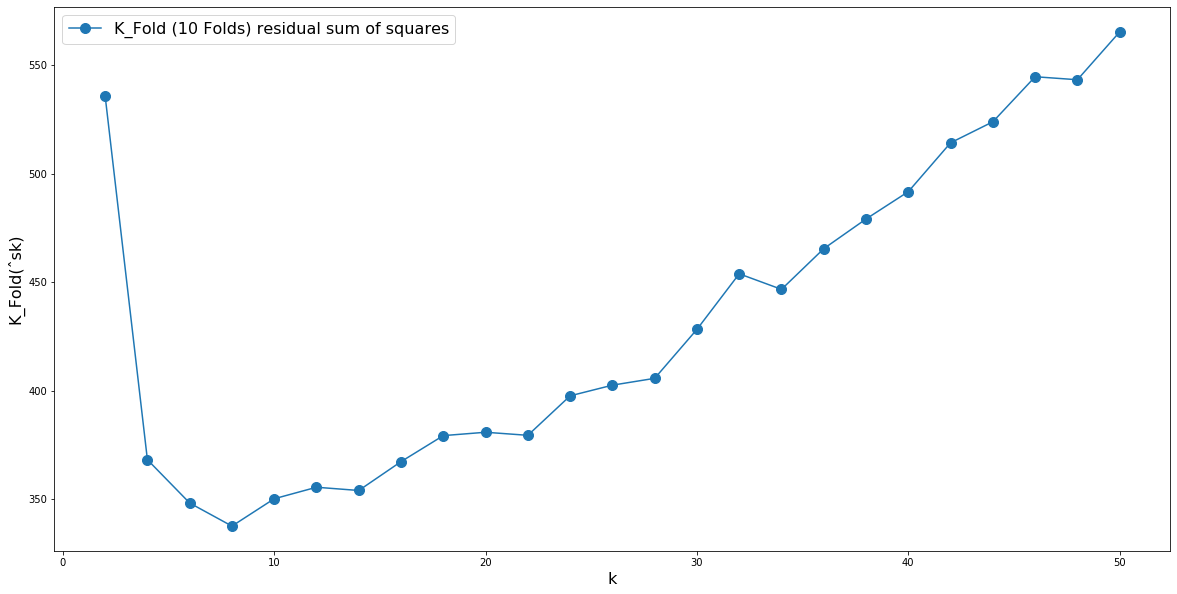

In [15]:
fig = plt.figure()
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.plot(K_seq_3, Values_3, '-o', markersize=10, label='K_Fold (10 Folds) residual sum of squares')
plt.legend(fontsize=16)
plt.xlabel('k', fontsize=16)
plt.ylabel('K_Fold(ˆsk)',fontsize=16)
plt.show()

Plot of Kfold (10 folds) residual sum of squares(sˆk) versus k for the constant-span running-mean smoother applied to the data. Good choices for k range between about `6 and 14`. The smaller values in this range would be especially good at bias reduction, whereas the larger ones would p

Lets compute average time for this model as well:

In [16]:
M = 50
K_seq_4 = np.arange(2, M+1, 2)
Values_4 = np.zeros(K_seq_4.size)
j = 0

start_time = time.time()
for i in K_seq_4:
    Values_4[j] = K_Fold(5, i,  X, Y)
    j += 1
    
C5_time = (time.time() - start_time) / j

<Figure size 432x288 with 0 Axes>

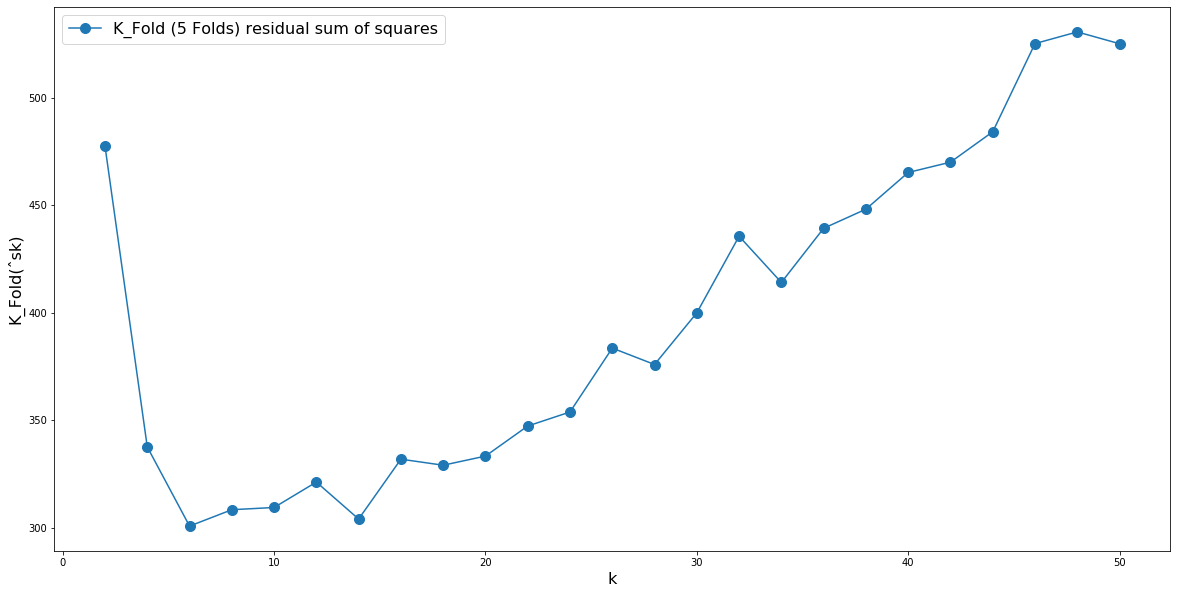

In [17]:
fig = plt.figure()
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.plot(K_seq_4, Values_4, '-o', markersize=10, label='K_Fold (5 Folds) residual sum of squares')
plt.legend(fontsize=16)
plt.xlabel('k', fontsize=16)
plt.ylabel('K_Fold(ˆsk)',fontsize=16)
plt.show()

Plot of Kfold (5 folds) residual sum of squares(sˆk) versus k for the constant-span running-mean smoother applied to the data. Good choices for k range between about `6 and 14`. The smaller values in this range would be especially good at bias reduction, whereas the larger ones would p

**5. using appropriate figures and tables to compare the plots A, B, C, and the corresponding
computational times.**

Lets plot all cross validations:

<Figure size 432x288 with 0 Axes>

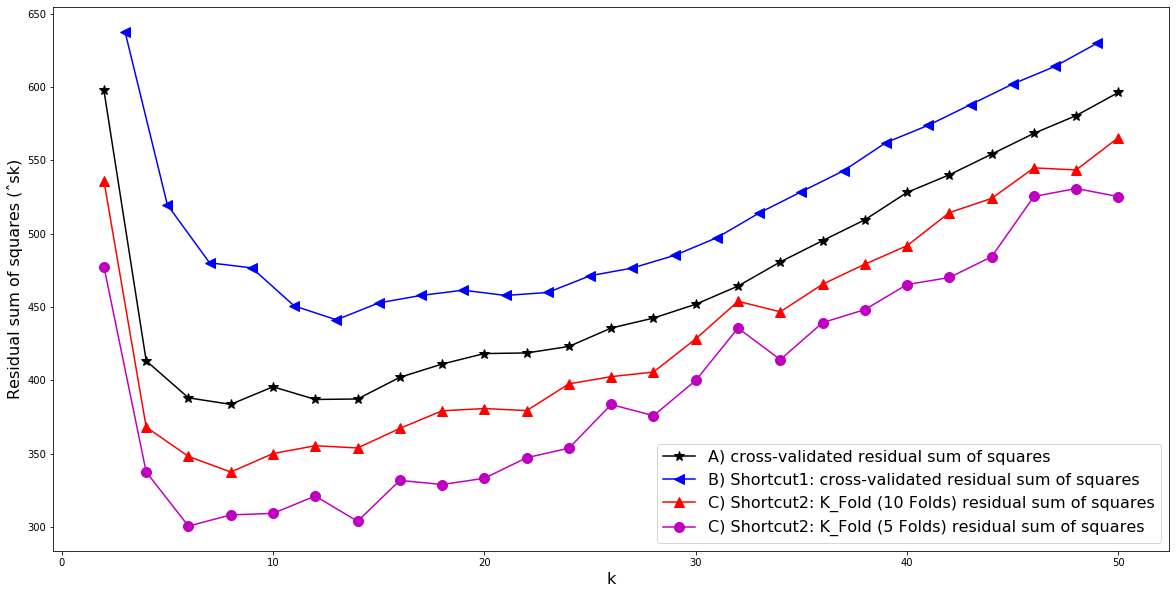

In [18]:
fig = plt.figure()
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.plot(K_seq, Values, 'k-*', markersize=10, label='A) cross-validated residual sum of squares')
ax.plot(K_seq_2, Values_2, 'b-<', markersize=10, label='B) Shortcut1: cross-validated residual sum of squares')
ax.plot(K_seq_3, Values_3, 'r-^', markersize=10, label='C) Shortcut2: K_Fold (10 Folds) residual sum of squares')
ax.plot(K_seq_4, Values_4, 'm-o', markersize=10, label='C) Shortcut2: K_Fold (5 Folds) residual sum of squares')
plt.legend(fontsize=16)
plt.xlabel('k', fontsize=16)
plt.ylabel('Residual sum of squares (ˆsk)',fontsize=16)
plt.show()

As evidant all method suggest a simillar range of K nearest for optimum trade off between bias and variance.

Now lets look at the average computaion time of each method (A, B, C10, C5) in secconds:

In [19]:
times = [A_time,B_time,C10_time,C5_time]
df = pd.DataFrame({'A) CVRSS':[A_time], 
                    'B) Shortcut1':[B_time], 
                    'C) Shortcut2 10_Folds':[C10_time],
                    'C) Shortcut2 5_Folds':[C5_time]}) 
df.head()

,A) CVRSS,B) Shortcut1,C) Shortcut2 10_Folds,C) Shortcut2 5_Folds
0,0.003118,0.002457,0.023135,0.029272


It can be seen that K_fold with 10 folds has the highest comuptation time compared to the rest due to spliting data into 10 folds. The fastest method is the shortcut 1. However Kfold with 5 folds is much faster that the original CVRSS method.